In [1]:
!pip install visualkeras
import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 16.3 MB/s eta 0:00:00a 0:00:01


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
folder_path = "../input/leukemia/Original"
Benign = os.listdir(folder_path + '/Benign/')
Early = os.listdir(folder_path + '/Early/')
Pre = os.listdir(folder_path + '/Pre/')
Pro = os.listdir(folder_path + '/Pro/')
dataset=[]
lab=[]

for image_name in Benign:
    image=cv2.imread(folder_path + '/Benign/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(0)
    
for image_name in Early:
    image=cv2.imread(folder_path + '/Early/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(1)
for image_name in Pre:
    image=cv2.imread(folder_path + '/Pre/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(2)
for image_name in Pro:
    image=cv2.imread(folder_path + '/Pro/' + image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    dataset.append(np.array(image))
    lab.append(3)

In [3]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(3256, 240, 240, 3) (3256,)


In [5]:
from sklearn.model_selection import train_test_split
!pip install split_folders
import splitfolders
import os
import shutil
from PIL import Image


# Set the random state value
random_state = 42

# Split the data into train, validation, and test sets using arrays
x_train_val, x_test, y_train_val, y_test = train_test_split(dataset, lab, test_size=0.2, shuffle=True, random_state=random_state)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=random_state)
print(f"train shape: {x_train.shape}- y_train shape: {y_train.shape}")
print(f"test shape: {x_test.shape}- y_test shape: {y_test.shape}")

train shape: (1953, 240, 240, 3)- y_train shape: (1953,)
test shape: (652, 240, 240, 3)- y_test shape: (652,)


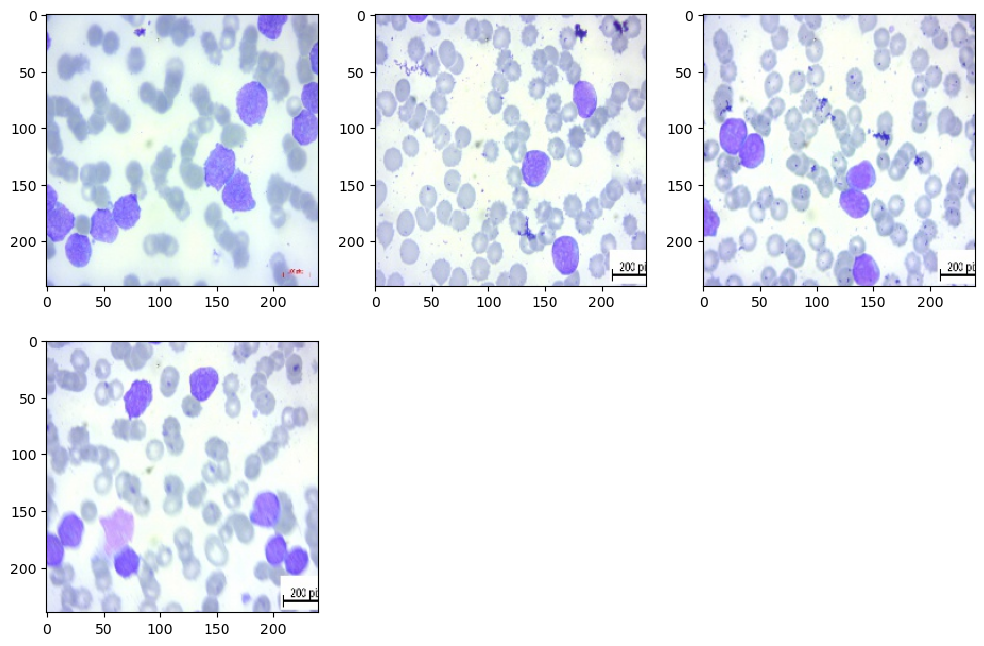

In [6]:
epochs = 50
pic_size = 240
np.random.seed(42)
tf.random.set_seed(42)
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 5, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()
plot_state('Early')

In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


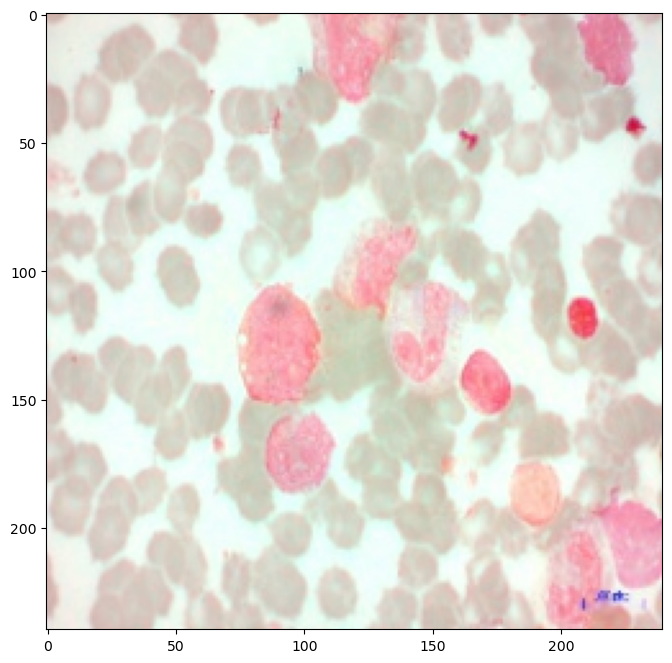

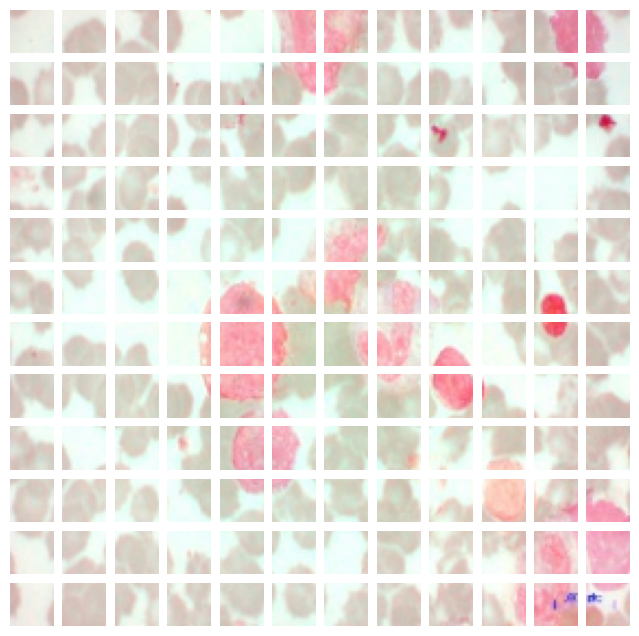

In [9]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
data_augmentation = tf.keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=(240, 240, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(4)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [14]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import save_model
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=tf.keras.utils.to_categorical(y_train, num_classes=4),
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, tf.keras.utils.to_categorical(y_val, num_classes=4)),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, tf.keras.utils.to_categorical(y_test, num_classes=4))
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Save the model
    #model.save("I:/8th semester/Thesis+Seminar/saved model/vit_model.h5")
    #print("ViT model saved successfully!")

    return history

vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/100
62/62 [==============================] - 23s 126ms/step - loss: 2.1995 - accuracy: 0.6656 - top-5-accuracy: 1.0000 - val_loss: 0.6798 - val_accuracy: 0.8264 - val_top-5-accuracy: 1.0000
Epoch 2/100
62/62 [==============================] - 7s 108ms/step - loss: 0.9424 - accuracy: 0.7527 - top-5-accuracy: 1.0000 - val_loss: 0.3704 - val_accuracy: 0.8940 - val_top-5-accuracy: 1.0000
Epoch 3/100
62/62 [==============================] - 7s 119ms/step - loss: 0.4681 - accuracy: 0.8658 - top-5-accuracy: 1.0000 - val_loss: 0.2565 - val_accuracy: 0.9155 - val_top-5-accuracy: 1.0000
Epoch 4/100
62/62 [==============================] - 6s 102ms/step - loss: 0.4157 - accuracy: 0.8848 - top-5-accuracy: 1.0000 - val_loss: 0.2339 - val_accuracy: 0.9293 - val_top-5-accuracy: 1.0000
Epoch 5/100
62/62 [==============================] - 5s 79ms/step - loss: 0.2842 - accuracy: 0.9227 - top-5-accuracy: 1.0000 - val_loss: 0.2586 - val_accuracy: 0.9171 - val_top-5-accuracy: 1.0000
Epoch 6/100
62/

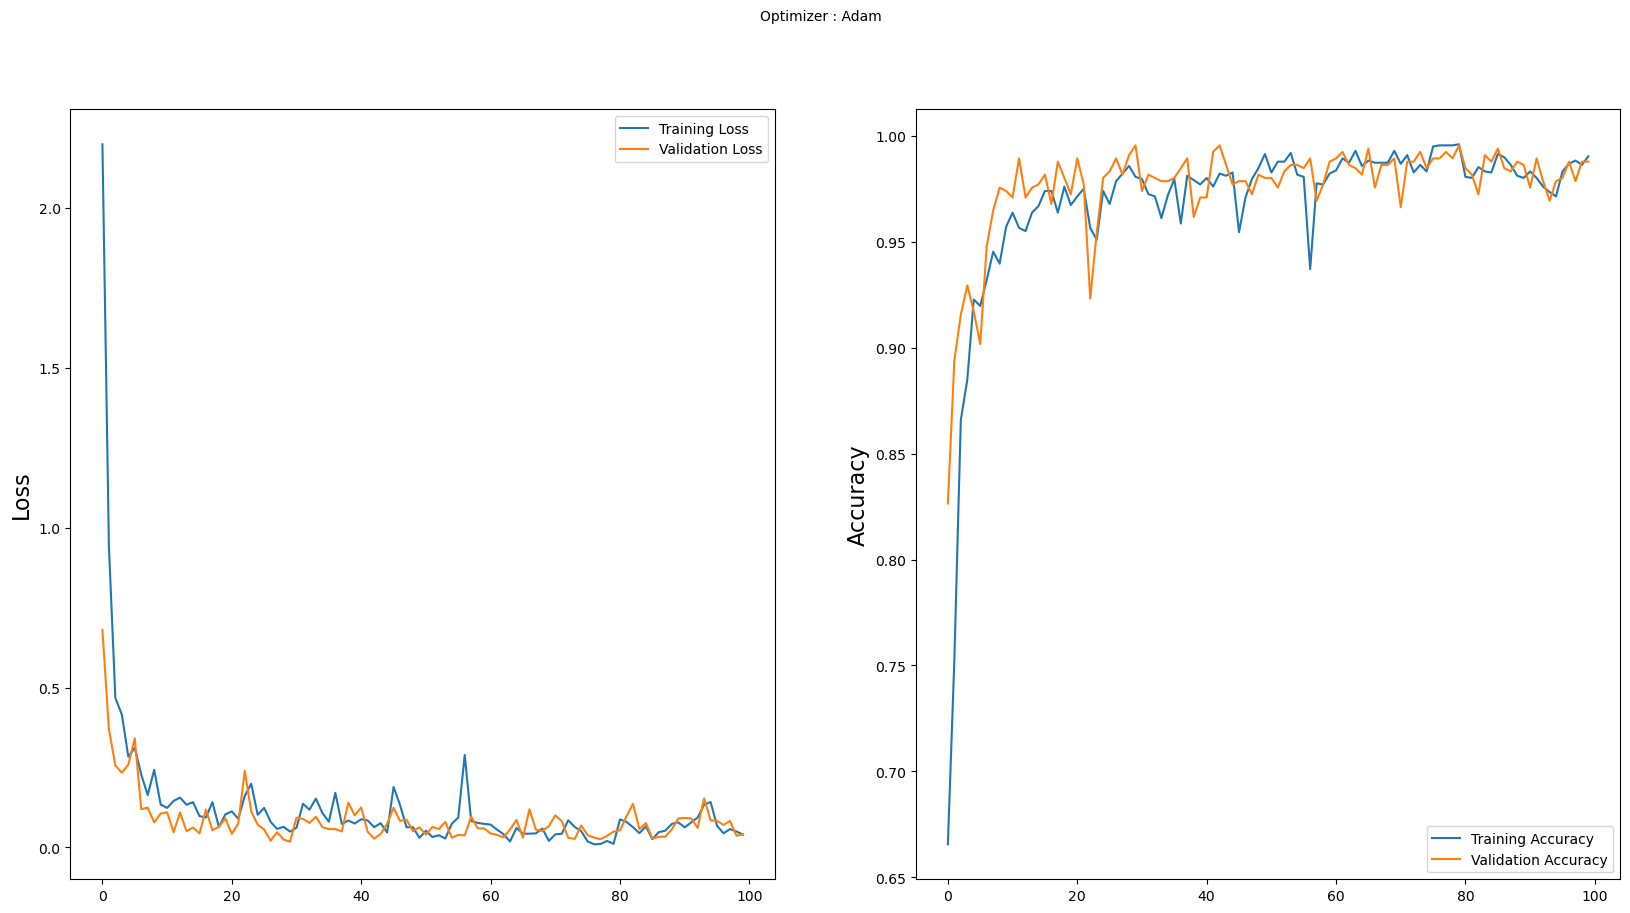

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(vit_history.history['loss'], label='Training Loss')
plt.plot(vit_history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vit_history.history['accuracy'], label='Training Accuracy')
plt.plot(vit_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import classification_report
vit_predictions = vit_classifier.predict(x_test)
vit_y_pred = np.argmax(vit_predictions, axis=1) # Convert predicted probabilities to class labels
#vit_pred = np.argmax(vit_predictions, axis=1)

# Calculate prediction accuracy
accuracy = (vit_y_pred == y_test).mean()
print(f"Prediction Accuracy: {accuracy}")

report = classification_report(y_test,vit_y_pred)

print("Classification Report:")
print(report)


21/21 [==============================] - 2s 32ms/step
Prediction Accuracy: 0.9923312883435583
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           1       0.99      0.99      0.99       196
           2       0.99      0.99      0.99       182
           3       0.99      1.00      1.00       150

    accuracy                           0.99       652
   macro avg       0.99      0.99      0.99       652
weighted avg       0.99      0.99      0.99       652



In [20]:

from keras.models import save_model

# Assuming you have a trained model called 'model'
#model = create_vit_classifier()  # Replace with your code to create the ViT model
# Train and/or load the weights of the model

# Save the model
#model.save("I:/8th semester/Thesis+Seminar/saved model/vit_model.h5")
#vit_classifier = create_vit_classifier()
# Train and/or load the weights of the model
save_model(vit_classifier,'/kaggle/working/vit.h5')

CNN****

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Define the CNN model
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(240, 240, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(units=4, activation='softmax')  # 4 classes, so 4 units in the output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if your labels are one-hot encoded
              metrics=['accuracy'])  # Add other evaluation metrics as needed

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")


Epoch 1/100
62/62 [==============================] - 7s 70ms/step - loss: 33.8134 - accuracy: 0.4977 - val_loss: 7.4209 - val_accuracy: 0.4101
Epoch 2/100
62/62 [==============================] - 4s 65ms/step - loss: 7.1151 - accuracy: 0.4839 - val_loss: 6.4369 - val_accuracy: 0.6651
Epoch 3/100
62/62 [==============================] - 4s 60ms/step - loss: 6.1935 - accuracy: 0.5617 - val_loss: 5.7548 - val_accuracy: 0.5668
Epoch 4/100
62/62 [==============================] - 4s 64ms/step - loss: 5.3395 - accuracy: 0.6641 - val_loss: 5.2237 - val_accuracy: 0.5837
Epoch 5/100
62/62 [==============================] - 4s 59ms/step - loss: 4.8688 - accuracy: 0.7215 - val_loss: 12.5487 - val_accuracy: 0.3103
Epoch 6/100
62/62 [==============================] - 4s 59ms/step - loss: 5.6209 - accuracy: 0.3717 - val_loss: 4.9758 - val_accuracy: 0.4209
Epoch 7/100
62/62 [==============================] - 4s 64ms/step - loss: 4.7775 - accuracy: 0.4050 - val_loss: 4.6715 - val_accuracy: 0.3917
Epoc

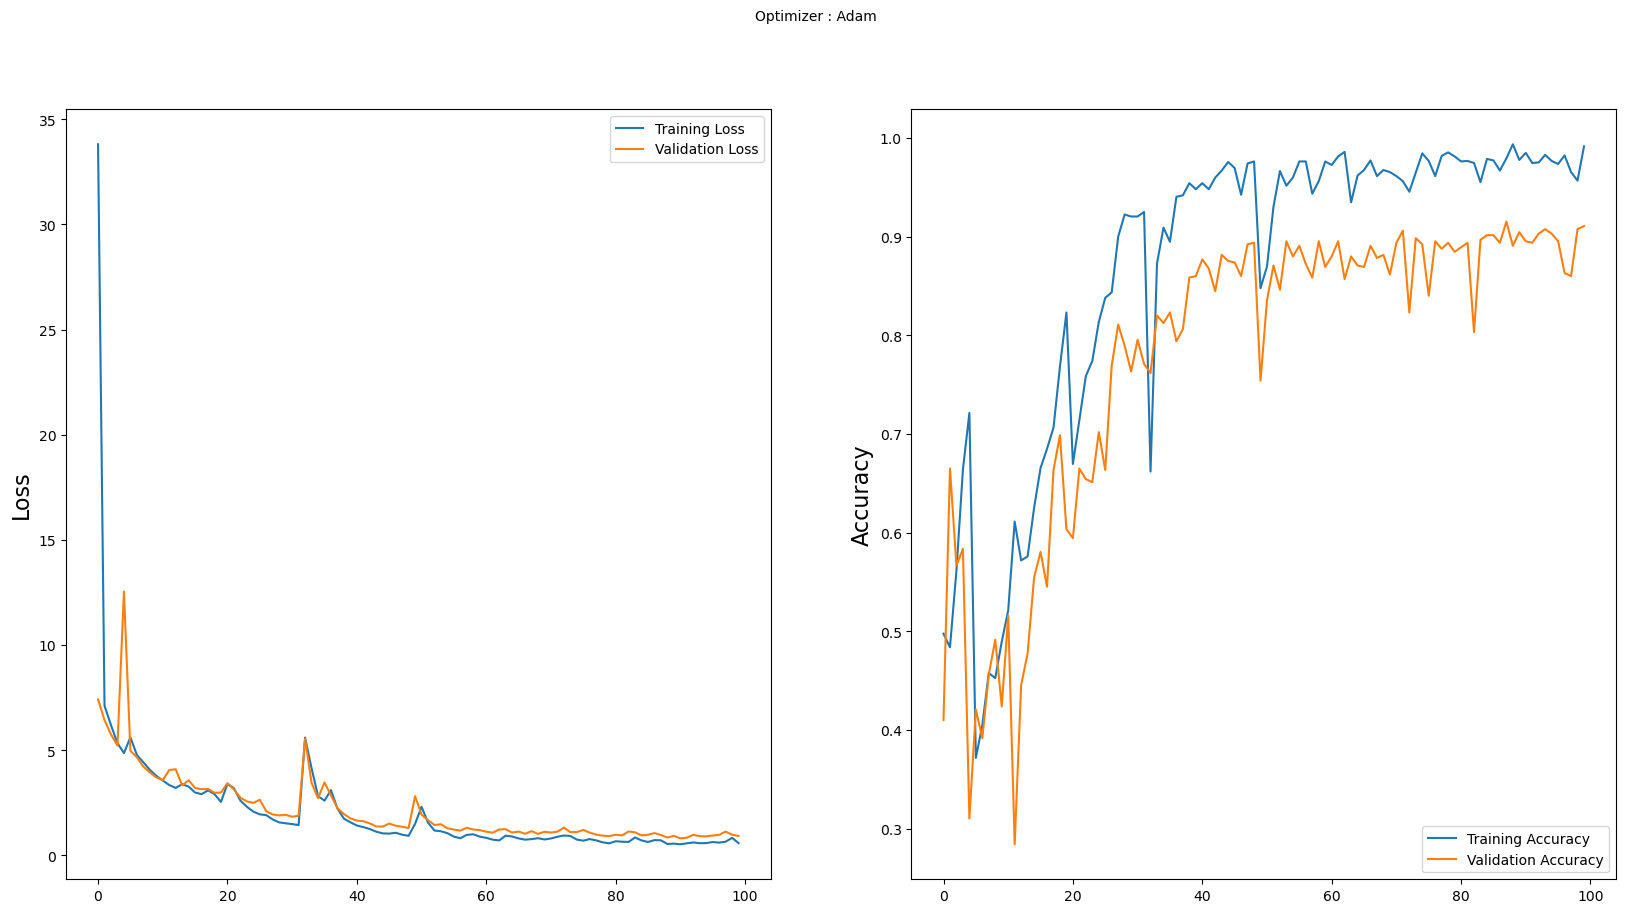

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [34]:
model.save("/kaggle/working/cnn1.h5")

In [35]:
import numpy as np
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class indices

# Generate the classification report
target_names = [f"Class {i}" for i in range(4)]  # Replace with actual class names if available
print(classification_report(y_test, y_pred_classes, target_names=target_names))


21/21 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

     Class 0       0.88      0.48      0.62       124
     Class 1       0.76      0.95      0.84       196
     Class 2       0.98      0.98      0.98       182
     Class 3       0.96      1.00      0.98       150

    accuracy                           0.88       652
   macro avg       0.89      0.85      0.85       652
weighted avg       0.89      0.88      0.87       652



In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 238, 238, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 119, 119, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 117, 117, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 28, 28, 128)     

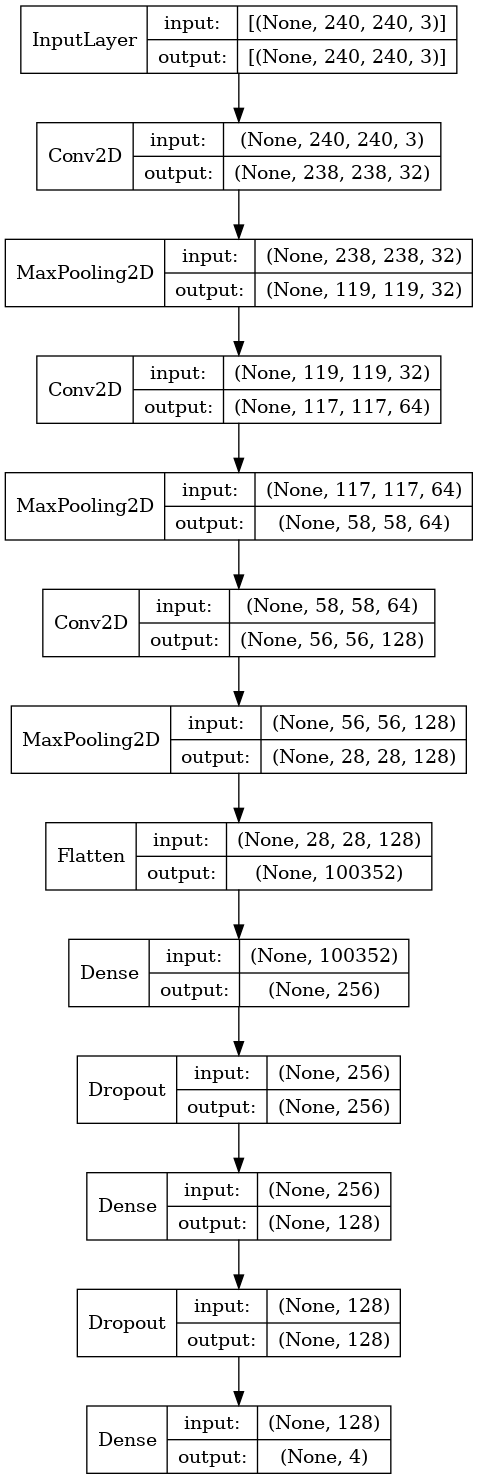

In [40]:
plot_model(model, show_shapes=True, show_layer_names=False)

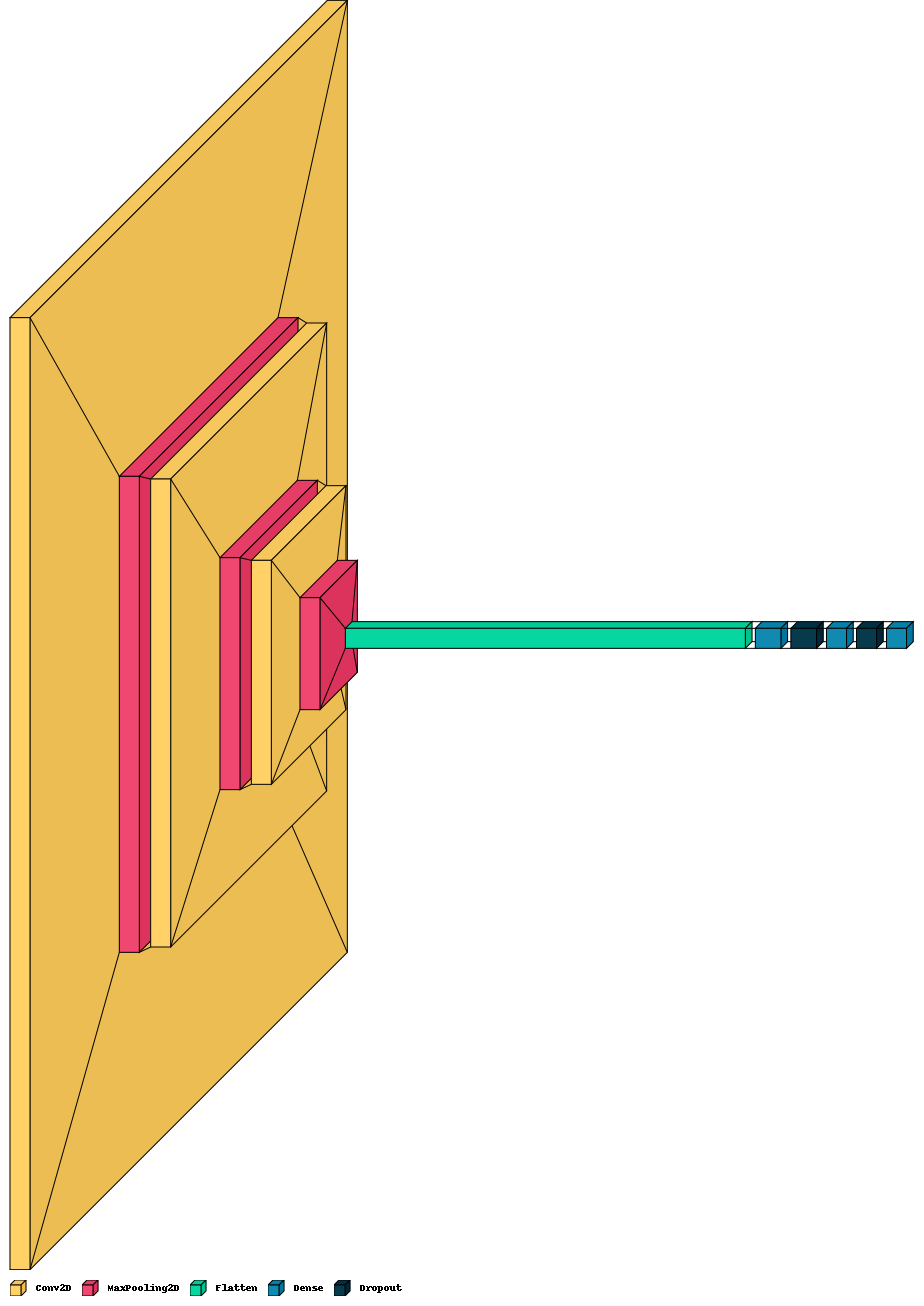

In [41]:
visualkeras.layered_view(model, legend=True)

In [38]:
import tensorflow as tf
from keras.models import load_model
custom_objects = {
    "Patches": Patches,
    "PatchEncoder": PatchEncoder,
}

#custom_objects = {"Patches": Patches}
#custom_objects = {"PatchEncoder": PatchEncoder}

# Load the saved VIT and CNN models
vit_model = tf.keras.models.load_model("/kaggle/working/vit.h5",custom_objects=custom_objects)
cnn_model = tf.keras.models.load_model("/kaggle/working/cnn1.h5")

# Make predictions on the test set using both models
vit_predictions = vit_model.predict(x_test)
cnn_predictions = cnn_model.predict(x_test)

# Define the weights for the ensemble (you can adjust these values based on your preference)
vit_weight = 0.6
cnn_weight = 0.4

# Combine the predictions using the weighted ensemble
ensemble_predictions = vit_weight * vit_predictions + cnn_weight * cnn_predictions

# Get the class indices with the highest probability for each sample
ensemble_pred_classes = np.argmax(ensemble_predictions, axis=1)

# Evaluate the ensemble's performance on the test set
from sklearn.metrics import accuracy_score, classification_report

ensemble_accuracy = accuracy_score(y_test, ensemble_pred_classes)
print(f"Ensemble Accuracy: {ensemble_accuracy}")

# Generate the classification report for the ensemble
target_names = [f"Class {i}" for i in range(4)]  # Replace with actual class names if available
print(classification_report(y_test, ensemble_pred_classes, target_names=target_names))


21/21 [==============================] - 0s 15ms/step
Ensemble Accuracy: 0.9938650306748467
              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99       124
     Class 1       1.00      0.99      0.99       196
     Class 2       0.99      0.99      0.99       182
     Class 3       0.99      1.00      1.00       150

    accuracy                           0.99       652
   macro avg       0.99      0.99      0.99       652
weighted avg       0.99      0.99      0.99       652

